# Lung Vessel Segmentation for Covid-19 diagnosis

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import nibabel as nib
from ipywidgets import interactive, fixed

from skimage import morphology as morpho
from skimage.measure import label
from skimage.color import label2rgb, rgb2gray
from skimage.filters import threshold_otsu
from scipy import ndimage as ndi
from skimage.morphology import skeletonize
from copy import deepcopy

## Image loading

In [4]:
filename = "../data/images/"+os.listdir("../data/images")[0]
filename_mask = "../data/lung_mask/"+os.listdir("../data/lung_mask")[0]

In [19]:
filename_mask

'../data/lung_mask/VESSEL12_09.nii'

In [5]:
img = nib.load(filename)
img_mask = nib.load(filename_mask)

im_arr = img.get_fdata()
mask_arr = img_mask.get_fdata()

In [4]:
sx, sy, sz = im_arr.shape

def show_axial(im_arr, mr_slice):
    plt.figure(figsize=(10, 10))
    plt.imshow(im_arr[:, :, mr_slice].T)
    plt.axis('off')
    plt.pause(0.1)
   
### Show the MR volume, slice by slice, in axial view
interactive_plot = interactive(show_axial, im_arr=fixed(im_arr), mr_slice=im_arr.shape[2]//2)
interactive_plot

interactive(children=(IntSlider(value=256, description='mr_slice', max=768, min=-256), Output()), _dom_classes…

## Preprocessing
Image normalization

In [6]:
def normalize(im):
    return 255*(im - im.mean())/im.max()

In [7]:
#example on one slice
im_test = normalize(im_arr[185])
im_mask_test = mask_arr[185]

In [8]:
def show(images, titles=None, size = 10):
    plt.figure(figsize=(size, size))
    for i in range(len(images)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i], cmap="gray")
        if (titles):
            plt.title(titles[i])
    plt.show()

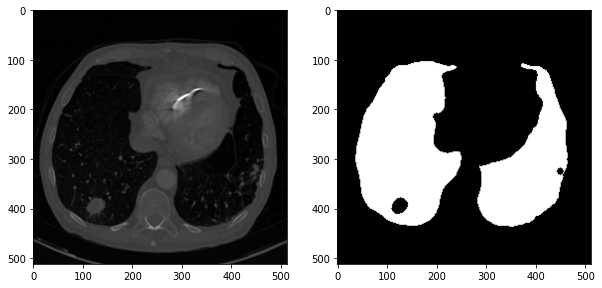

In [9]:
show([im_test, im_mask_test])

In [10]:
def apply_mask(image, mask):
    return image*mask

Binarisation and apply mask on the lungs

## Segmentation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


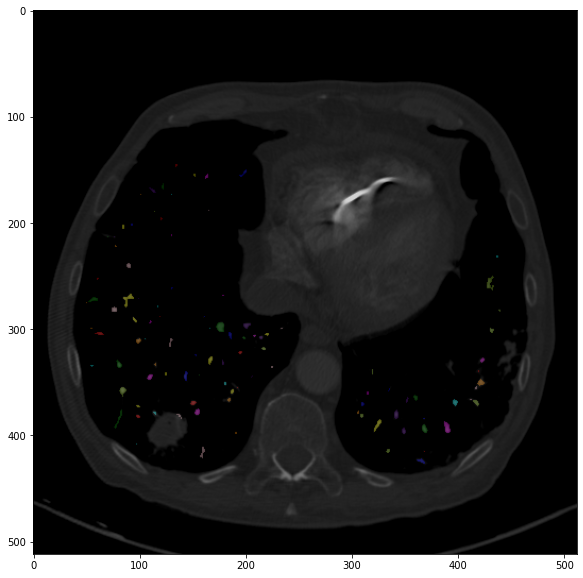

In [11]:
## LOAD RORPO ##
mg = nib.load("test_label.nii").get_fdata()
rorpo = mg[185]
show([mg[185]])

In [16]:
rorpo.shape

(512, 512, 3)

In [12]:
rorpo[:, :, 0] *= im_mask_test
rorpo[:, :, 1] *= im_mask_test
rorpo[:, :, 2] *= im_mask_test

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


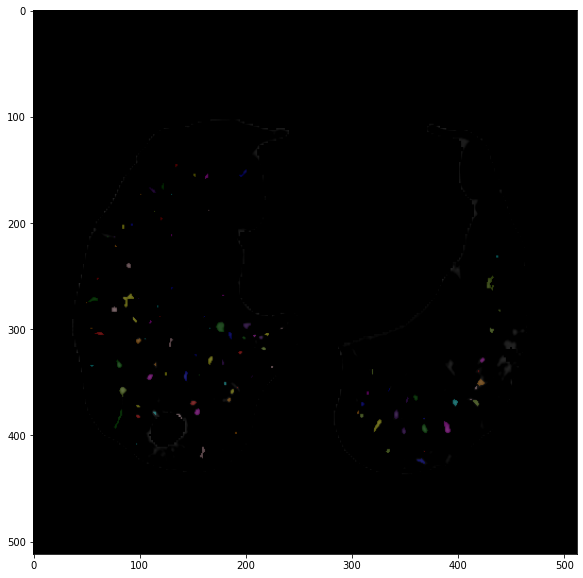

In [13]:
show([rorpo])

In [14]:
test_rorpo = deepcopy(rorpo)

In [15]:
test_rorpo_gray = test_rorpo@[0.3, 0.6, 0.1]

In [84]:
bin_rorpo = (test_rorpo_gray > threshold_otsu(test_rorpo_gray)).astype(int)
bin_rorpo = bin_rorpo * morpho.erosion(im_mask_test, morpho.disk(2))

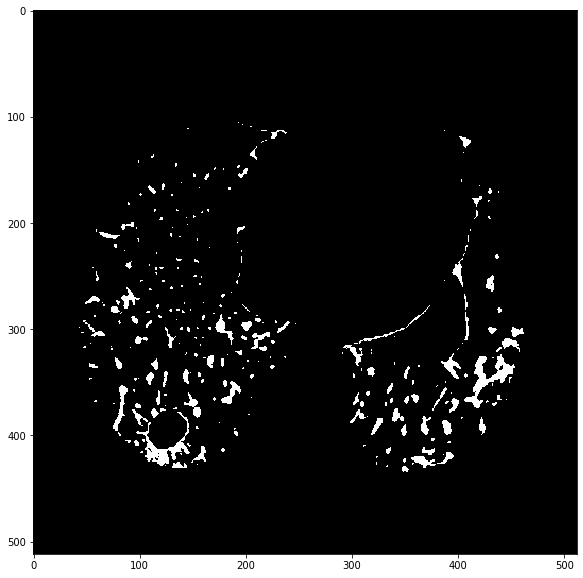

In [85]:
show([bin_rorpo])

In [50]:
# test_rorpo[test_rorpo != 0] = 1

## Distance map

In [86]:
distance = ndi.distance_transform_edt(bin_rorpo)

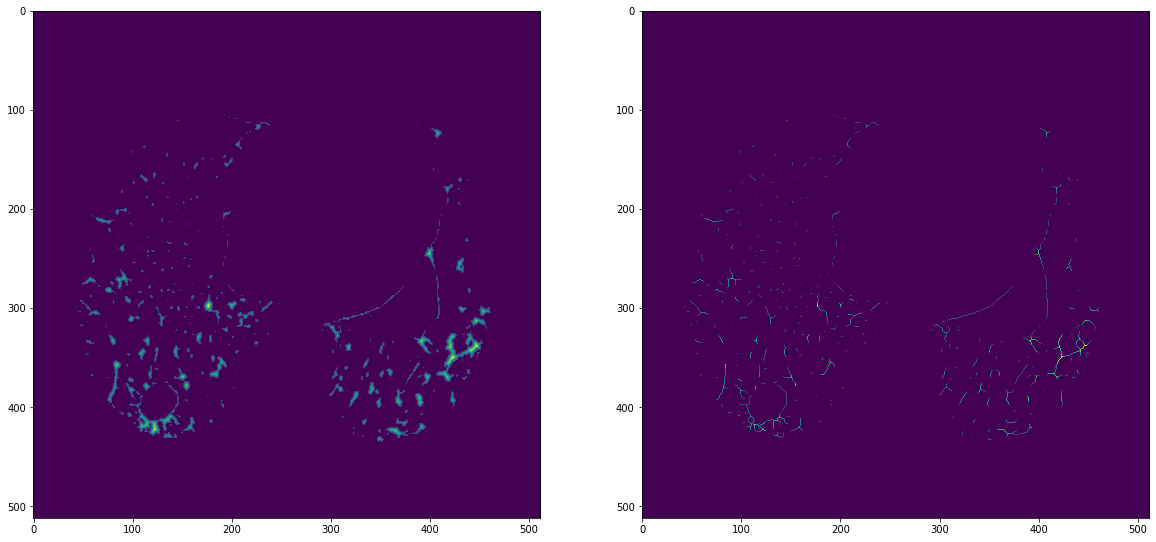

In [121]:
plt.figure(figsize=(20, 20))
plt.subplot(121)
plt.imshow(distance)
plt.subplot(122)
skeleton = skeletonize(bin_rorpo)
plt.imshow(skeleton*distance)
plt.show()

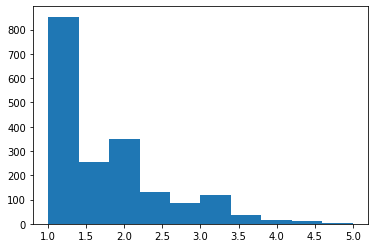

In [119]:
skel = (skeleton*distance).flatten()
plt.hist(np.delete(skel, np.where(skel == 0)))
plt.show()